# Movielens 영화 SBR   
(Session-based Recommendation)

<참고 사항>   

* 여기서 이전 실습내역과 가장 크게 다른 부분은 바로 SessionID 대신 UserID 항목이 들어갔다는 점입니다. 이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있습니다. 그래서 이번에는 UserID가 SessionID 역할을 해야 합니다.

* Rating 정보가 포함되어 있습니다. 이전 실습내역에서는 이런 항목이 포함되어 있지 않았으므로, 무시하고 제외할 수 있습니다. 하지만, 직전에 봤던 영화가 맘에 들었는지 여부가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있습니다. 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 합니다.

* Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초단위 시간이 기재되어 있습니다.

## Step 1. 데이터의 전처리
위와 같이 간단히 구성해 본 데이터셋을 꼼꼼이 살펴보면서 항목별 기본분석, session length, session time, cleaning 등의 작업을 진행합니다.
특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.

<Readme에서 빼온 데이터 자료>   

UserID::MovieID::Rating::Timestamp

- UserIDs range between 1 and 6040 
- MovieIDs range between 1 and 3952
- Ratings are made on a 5-star scale (whole-star ratings only)
- Timestamp is represented in seconds since the epoch as returned by time(2)
- Each user has at least 20 ratings

### 1) 데이터 로드  

In [1]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose-data/ml-1m') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [3]:
#추천 시스템 구축할때 가장 먼저 확인 할 것은, 유저수 (세션 수)와 아이템 수 
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

같은 user가 다른 영화를ㄹ 보고 평점을 남길 수도 있음.   
각 userID가 대략 몇 개의 클릭 데이터를 갖는지 session_length로 확인

### Counting User's Ratings 

In [4]:
user_rating_cnt = data.groupby('UserId').size()
user_rating_cnt

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [5]:
time_rating_cnt = data.groupby('Time').size()
time_rating_cnt

Time
956703932     1
956703954     2
956703977     2
956704056     5
956704081     1
             ..
1046454320    1
1046454338    1
1046454443    1
1046454548    2
1046454590    1
Length: 458455, dtype: int64

In [6]:
user_time_rating_cnt = data.groupby(['UserId', 'Time']).size()
user_time_rating_cnt

UserId  Time     
1       978300019    1
        978300055    3
        978300103    1
        978300172    1
        978300275    1
                    ..
6040    997454398    1
        997454429    1
        997454464    2
        997454486    1
        998315055    1
Length: 471163, dtype: int64

In [7]:
rating_cnt = data.groupby('Rating').size()
rating_cnt

Rating
1     56174
2    107557
3    261197
4    348971
5    226310
dtype: int64

In [8]:
ser_rating_cnt = data.groupby(['UserId', 'Rating']).size()
user_rating_cnt

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

* User_rating_cnt = 사용자가 영화를 보고 몇번 Rate 하였는지를 의미함 

In [9]:
time_rating_cnt.median(), time_rating_cnt.mean()


(2.0, 2.181695040952765)

In [10]:
user_rating_cnt.median(), user_rating_cnt.mean()


(96.0, 165.5975165562914)

In [11]:
user_time_rating_cnt.median(), user_time_rating_cnt.mean()


(2.0, 2.1228513274599234)

In [12]:
rating_cnt.median(), rating_cnt.mean()


(226310.0, 200041.8)

In [13]:
user_rating_cnt.median(), user_rating_cnt.mean()


(96.0, 165.5975165562914)

In [14]:
time_rating_cnt.min(), time_rating_cnt.max()


(1, 30)

In [15]:
user_rating_cnt.min(), user_rating_cnt.max()


(20, 2314)

In [16]:
user_time_rating_cnt.min(), user_time_rating_cnt.max()


(1, 30)

In [17]:
rating_cnt.min(), rating_cnt.max()


(56174, 348971)

In [18]:
user_rating_cnt.min(), user_rating_cnt.max()


(20, 2314)

* UserId별 Rating 횟수는 보통 2개 정도 
* 같은 시간 (초)에 30개 이상의 Rating이 있는 부분이 있음 -> 확인 필요 

In [19]:
time_rating_cnt.quantile(0.999)


12.0

In [20]:
user_rating_cnt.quantile(0.999)


1343.181000000005

In [21]:
user_time_rating_cnt.quantile(0.999)


10.0

In [22]:
rating_cnt.quantile(0.999)


348619.90400000004

* 마지막 5개의 Rating은 (1024176337 - 1024174347) % 60 = 33.1 분 동안 이뤄짐
* 이벤트 참석으로 영화 평점 조작으로 느껴지기 때문에 "같은 사용자가 동일한 시간에 Rating한 데이터"는 삭제 조치 

In [23]:
data=data.drop_duplicates(subset=['UserId', 'Time'], keep='first')
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
24,1,2340,3,978300103
36,1,1836,5,978300172
3,1,3408,4,978300275
...,...,...,...,...
999923,6040,232,5,997454398
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000167,6040,161,3,997454486


In [24]:
#삭제 후의 userid 와 itemid의 유닉한 개수
data['UserId'].nunique(), data['ItemId'].nunique()


(6040, 3600)

In [25]:
#사용자 rating 갯수에 대한 시각화 
data['Datetime'] = pd.to_datetime('1970-01-01')
data['Datetime'] = pd.to_datetime(data['Datetime'], format="%Y-%m-%d %H:%M:%S")
data.dtypes

UserId               int32
ItemId               int32
Rating               int32
Time                 int64
Datetime    datetime64[ns]
dtype: object

In [26]:
data


,UserId,ItemId,Rating,Time,Datetime
31,1,3186,4,978300019,1970-01-01
22,1,1270,5,978300055,1970-01-01
24,1,2340,3,978300103,1970-01-01
36,1,1836,5,978300172,1970-01-01
3,1,3408,4,978300275,1970-01-01
...,...,...,...,...,...
999923,6040,232,5,997454398,1970-01-01
1000019,6040,2917,4,997454429,1970-01-01
999988,6040,1921,4,997454464,1970-01-01
1000167,6040,161,3,997454486,1970-01-01


In [27]:
#timedelta로 초 시간을 년월일 형식으로 변경
data.Datetime = data.Datetime + data.Time.map(lambda x : dt.timedelta(seconds=x))
data

,UserId,ItemId,Rating,Time,Datetime
31,1,3186,4,978300019,2000-12-31 22:00:19
22,1,1270,5,978300055,2000-12-31 22:00:55
24,1,2340,3,978300103,2000-12-31 22:01:43
36,1,1836,5,978300172,2000-12-31 22:02:52
3,1,3408,4,978300275,2000-12-31 22:04:35
...,...,...,...,...,...
999923,6040,232,5,997454398,2001-08-10 14:39:58
1000019,6040,2917,4,997454429,2001-08-10 14:40:29
999988,6040,1921,4,997454464,2001-08-10 14:41:04
1000167,6040,161,3,997454486,2001-08-10 14:41:26


In [28]:
user_rating_cnt = data.groupby('UserId').size()
user_rating_cnt

UserId
1        34
2        66
3        31
4         7
5        83
       ... 
6036    189
6037     56
6038     14
6039     46
6040    168
Length: 6040, dtype: int64

In [29]:

user_rating_cumsum = user_rating_cnt.cumsum() / user_rating_cnt.sum()
user_rating_cnt.cumsum()

UserId
1           34
2          100
3          131
4          138
5          221
         ...  
6036    470879
6037    470935
6038    470949
6039    470995
6040    471163
Length: 6040, dtype: int64

In [30]:
user_rating_cnt.sum()


471163

In [31]:
#user별로 남긴 rating에 대한 cumsum 
user_rating_cumsum

UserId
1       0.000072
2       0.000212
3       0.000278
4       0.000293
5       0.000469
          ...   
6036    0.999397
6037    0.999516
6038    0.999546
6039    0.999643
6040    1.000000
Length: 6040, dtype: float64

In [34]:
user_rating_cumsum_999 = user_rating_cumsum[user_rating_cumsum < 0.999]

In [36]:
user_rating_cumsum_999

UserId
1       0.000072
2       0.000212
3       0.000278
4       0.000293
5       0.000469
          ...   
6031    0.998578
6032    0.998686
6033    0.998729
6034    0.998737
6035    0.998996
Length: 6035, dtype: float64

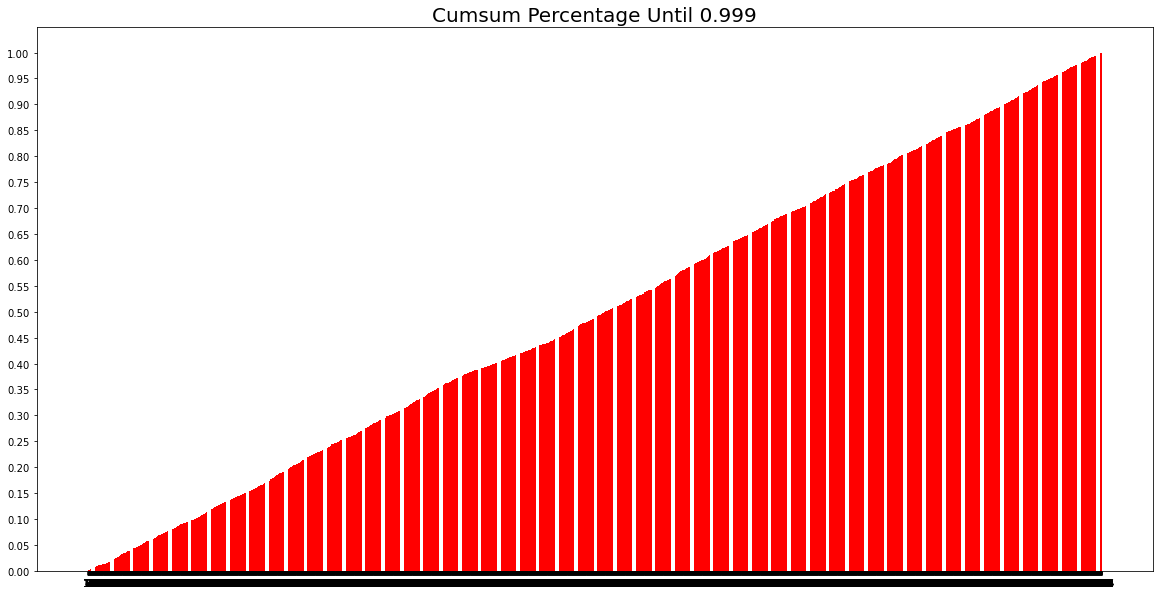

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=user_rating_cumsum_999.index,
        height=user_rating_cumsum_999, color='red')
plt.xticks(user_rating_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

* 추천 시스템은 유저-상품 관계를 유저 행렬 x 상품 행렬로 표현하는 Matrix Factorization 모델을 많이 사용함   
* movielens도 동일하게 marix factorization 사용해서 표현 해봄
* 해당 세션 정보는 userid를 기반으로 정리할 수 없기 때문에, 세션 하나를 유저 하나로 보면, 기존의 유저-상품정보 매트릭수 보다 더욱 펼쳐진 sparse한 형태를 가짐 

### User Time : 다루려는 데이터의 시간관련 정보 확인

In [37]:
oldest, latest = data['Datetime'].min(), data['Datetime'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [38]:
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

미래의 데이터를 가져온걸까. 2030년이 가장 oldest한 데이터임.. 
* latest는 Timestamp 객체이기 때문에 int객체와의 사칙연산을 지원하지 않음. 
* 날짜끼리의 차이를 구하고 싶을 때는 datetime라이브러리의 tiemdelta 객체 사용 필요! 

In [39]:
month_ago = latest - dt.timedelta(1040)     # 최종 날짜로부터 1040일 이전 날짜를 구한다.  
data = data[data['Datetime'] > month_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
data

,UserId,ItemId,Rating,Time,Datetime
31,1,3186,4,978300019,2000-12-31 22:00:19
22,1,1270,5,978300055,2000-12-31 22:00:55
24,1,2340,3,978300103,2000-12-31 22:01:43
36,1,1836,5,978300172,2000-12-31 22:02:52
3,1,3408,4,978300275,2000-12-31 22:04:35
...,...,...,...,...,...
999923,6040,232,5,997454398,2001-08-10 14:39:58
1000019,6040,2917,4,997454429,2001-08-10 14:40:29
999988,6040,1921,4,997454464,2001-08-10 14:41:04
1000167,6040,161,3,997454486,2001-08-10 14:41:26


### Data Cleansing    
* Rating 1이상 일때의 경우, 선호도를 예측하는 것이 목표이므로, Rating 1-3까지 데이터 모두 제거해줌 

In [40]:
idx_rating = data[data['Rating']<3].index
data = data.drop(idx_rating)
data

,UserId,ItemId,Rating,Time,Datetime
31,1,3186,4,978300019,2000-12-31 22:00:19
22,1,1270,5,978300055,2000-12-31 22:00:55
24,1,2340,3,978300103,2000-12-31 22:01:43
36,1,1836,5,978300172,2000-12-31 22:02:52
3,1,3408,4,978300275,2000-12-31 22:04:35
...,...,...,...,...,...
999923,6040,232,5,997454398,2001-08-10 14:39:58
1000019,6040,2917,4,997454429,2001-08-10 14:40:29
999988,6040,1921,4,997454464,2001-08-10 14:41:04
1000167,6040,161,3,997454486,2001-08-10 14:41:26


### Train/Valid/ Test Split   
* 모델 평가를 위한 valid set & test set 만들어보기    
* 주어지는 test set 이 있음 

In [41]:

def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Datetime'].max()
    user_last_time = data.groupby('UserId')['Datetime'].max()
    user_in_train = user_last_time[user_last_time < final_time - dt.timedelta(n_days)].index
    user_in_test = user_last_time[user_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['UserId'].isin(user_in_train)]
    after_date = data[data['UserId'].isin(user_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [42]:
tr, test = split_by_date(data, n_days=10) # 최종 날짜로부터 10일 이전 날짜로 Test 데이터를 구성한다.
tr, val = split_by_date(tr, n_days=30)    # 최종 날짜로부터 30일 이전 날짜로 Val 데이터를 구성한다.

In [43]:

# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Users: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Datetime"].min()}\n'
          f'\t Last Time : {data["Datetime"].max()}\n')

In [44]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')


* train Set Stats Info
	 Events: 366247
	 Users: 5911
	 Items: 3519
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2003-01-19 04:47:17

* valid Set Stats Info
	 Events: 14429
	 Users: 76
	 Items: 2491
	 First Time : 2000-05-05 17:20:21
	 Last Time : 2003-02-18 17:36:46

* test Set Stats Info
	 Events: 14545
	 Users: 52
	 Items: 2580
	 First Time : 2000-05-01 11:15:13
	 Last Time : 2003-02-28 17:49:50



In [45]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

이제 데이터 준비 완료.   
데이터 저장 후 data pipeline 구축하는 단계로 넘어가겠음 

In [46]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')


## Step 2. 미니 배치의 구성
실습코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다. Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.
단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다.


#### Data Pipeline   
* Session-Parallel Mini-Batch 구현해보기 

In [47]:
#데이터가 주어지면 User가 시작되는 인덱스를 담는 값과 User를 새로 인덱싱한 값을 갖는 클래스를 만듭니다.
class UserDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.user_idx = np.arange(self.df['UserId'].nunique())  # indexing to UserId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each User IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

* click_offsets 변수는 각 User가 시작된 인덱스를 담고 있음. 
* user_idx 변수는 각 User를 인덱싱한 np.array 입음.

In [48]:
tr_dataset = UserDataset(tr)
tr_dataset.df.head(100)

,UserId,ItemId,Rating,Time,Datetime,item_idx
31,1,3186,4,978300019,2000-12-31 22:00:19,0
22,1,1270,5,978300055,2000-12-31 22:00:55,1
24,1,2340,3,978300103,2000-12-31 22:01:43,2
36,1,1836,5,978300172,2000-12-31 22:02:52,3
3,1,3408,4,978300275,2000-12-31 22:04:35,4
...,...,...,...,...,...,...
202,3,2858,4,978297039,2000-12-31 21:10:39,92
186,3,3534,3,978297068,2000-12-31 21:11:08,93
190,3,1431,3,978297095,2000-12-31 21:11:35,94
209,3,1266,5,978297396,2000-12-31 21:16:36,95


In [49]:
tr_dataset.click_offsets

array([     0,     34,     94, ..., 366064, 366109, 366247], dtype=int32)

In [50]:
tr_dataset.user_idx

array([   0,    1,    2, ..., 5908, 5909, 5910])

### User Data Loader    
* UserDataset 객체를 받아서 User-Parallel mini-batch를 만드는 클래스를 만듭니다.
*iter 메소드는 모델 인풋, 라벨, 세션이 끝나는 곳의 위치를 yield합니다.
* mask는 후에 RNN Cell State를 초기화 하는데 사용할 것입니다.

In [51]:
class UserDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: UserDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing user-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the users to be terminated
        """

        start, end, mask, last_user, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where User Start
        end : Index Where User End
        mask : indicator for the users to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Users
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_user, finished = self.update_status(start, end, min_len, last_user, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 User Index를 가져옵니다.
        last_user = self.batch_size - 1    # 마지막으로 다루고 있는 User Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.user_idx[first_iters]]       # data 상에서 user가 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.user_idx[first_iters] + 1]  # user가 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # user의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_user, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_user: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 User가 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 User 개수만큼 새로운 User을 돌것입니다.
            new_user = last_user + i  
            if new_user > self.dataset.user_idx[-1]:  # 만약 새로운 User이 마지막 User index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.user_idx[new_user]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.user_idx[new_user] + 1]

        last_user += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_user, finished

In [52]:
tr_data_loader = UserDataLoader(tr_dataset, batch_size=50)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,Datetime,item_idx
31,1,3186,4,978300019,2000-12-31 22:00:19,0
22,1,1270,5,978300055,2000-12-31 22:00:55,1
24,1,2340,3,978300103,2000-12-31 22:01:43,2
36,1,1836,5,978300172,2000-12-31 22:02:52,3
3,1,3408,4,978300275,2000-12-31 22:04:35,4
7,1,2804,5,978300719,2000-12-31 22:11:59,5
0,1,1193,5,978300760,2000-12-31 22:12:40,6
9,1,919,4,978301368,2000-12-31 22:22:48,7
51,1,608,4,978301398,2000-12-31 22:23:18,8
43,1,2692,4,978301570,2000-12-31 22:26:10,9


In [53]:
iter_ex = iter(tr_data_loader)

In [54]:
#아래 셀 반복 실행하면 next가 계속 다음 데이터를 만듬 
# input, output, mask에 대한 감 잡아보기 
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [   0   34   42   35  114  175    1   35  256  201   34  505   26  526
  532  573  579  432  660   11  616   48  207  447  812   42  695    6
  956   16  963  447  978 1050   71  801  635  328 1147  199   22    6
   76 1172  918 1203    6   26   87 1207]
Label Item Idx are :       [   1   35   92   16   92  176   99  206  257  293  328   34  508  527
   34  321  262  441   42  135  610   35   42  322   34  823  281  944
  957  958  964  175   48  925 1063    1   26  175  135  289 1157 1160
   10  191 1011  482  432 1212  279  432]
Previous Masked Input Idx are []


## Step 3. 모델 구성
이 부분도 실습코드 내역을 참고하여 다양하게 모델 구조를 시도해볼 수 있습니다.

In [55]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

#### Model Architecture    
모델 구조 구현 해보기

In [56]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [57]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [58]:
#모델에 사용할 hyper-parameter를 class형식으로 관리 
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_users = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=50, hsz=50, drop_rate=0.1, lr=0.001, epochs=20, k=20)

In [59]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(50, 1, 3519)]           0         
_________________________________________________________________
GRU (GRU)                    [(50, 50), (50, 50)]      535650    
_________________________________________________________________
dropout (Dropout)            (50, 50)                  0         
_________________________________________________________________
dense (Dense)                (50, 3519)                179469    
Total params: 715,119
Trainable params: 715,119
Non-trainable params: 0
_________________________________________________________________


### Step 4. 모델 학습   
* 다양한 하이퍼파라미터를 변경해 보며 검증해 보도록 합니다. 실습코드에 언급되었던 Recall, MRR 등의 개념들도 함께 관리될 수 있도록 합니다.

#### Model Training 

In [60]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = UserDataset(args.tr)
    train_loader = UserDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 user은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\n\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = UserDataset(data)
    loader = UserDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [61]:
# 학습 시간이 다소 오래 소요됩니다. (예상시간 1시간)
train_model(model, args)

Train:   0%|          | 0/7206 [00:00<?, ?it/s, accuracy=0.02, train_loss=6.5] 


	 - Recall@20 epoch 1: 0.126061
	 - MRR@20    epoch 1: 0.032780




Train:   0%|          | 0/7206 [00:00<?, ?it/s, accuracy=0, train_loss=6.31]   


	 - Recall@20 epoch 2: 0.176667
	 - MRR@20    epoch 2: 0.046901




Train:   0%|          | 0/7206 [00:00<?, ?it/s, accuracy=0, train_loss=6.27]   


	 - Recall@20 epoch 3: 0.191818
	 - MRR@20    epoch 3: 0.051434




Train:   0%|          | 0/7206 [00:00<?, ?it/s, accuracy=0, train_loss=6.17]   


	 - Recall@20 epoch 4: 0.204394
	 - MRR@20    epoch 4: 0.054127




Train:   0%|          | 0/7206 [00:00<?, ?it/s, accuracy=0.04, train_loss=6.01]


	 - Recall@20 epoch 5: 0.212424
	 - MRR@20    epoch 5: 0.056254




Train:   0%|          | 0/7206 [00:00<?, ?it/s, accuracy=0.06, train_loss=5.92]


	 - Recall@20 epoch 6: 0.212273
	 - MRR@20    epoch 6: 0.056451




Train:   0%|          | 0/7206 [00:00<?, ?it/s, accuracy=0.02, train_loss=5.94]


	 - Recall@20 epoch 7: 0.214091
	 - MRR@20    epoch 7: 0.057227




Train:   0%|          | 0/7206 [00:00<?, ?it/s, accuracy=0.04, train_loss=5.81]


	 - Recall@20 epoch 8: 0.213182
	 - MRR@20    epoch 8: 0.058415




Train:   0%|          | 0/7206 [00:00<?, ?it/s, accuracy=0.02, train_loss=5.96]


	 - Recall@20 epoch 9: 0.212727
	 - MRR@20    epoch 9: 0.059116




Train:   0%|          | 0/7206 [00:00<?, ?it/s, accuracy=0.02, train_loss=5.95]


	 - Recall@20 epoch 10: 0.213485
	 - MRR@20    epoch 10: 0.058658




Train:   0%|          | 0/7206 [00:00<?, ?it/s, accuracy=0, train_loss=5.71]   


	 - Recall@20 epoch 11: 0.210909
	 - MRR@20    epoch 11: 0.059027




Train:   0%|          | 0/7206 [00:00<?, ?it/s, accuracy=0.08, train_loss=5.63]


	 - Recall@20 epoch 12: 0.212424
	 - MRR@20    epoch 12: 0.058909




Train:   0%|          | 0/7206 [00:00<?, ?it/s, accuracy=0.1, train_loss=5.61] 


	 - Recall@20 epoch 13: 0.209848
	 - MRR@20    epoch 13: 0.059375




Train:   0%|          | 0/7206 [00:00<?, ?it/s, accuracy=0.1, train_loss=5.56] 


	 - Recall@20 epoch 14: 0.210303
	 - MRR@20    epoch 14: 0.058292




Train:   0%|          | 0/7206 [00:00<?, ?it/s, accuracy=0, train_loss=5.57]   


	 - Recall@20 epoch 15: 0.207273
	 - MRR@20    epoch 15: 0.057858




Train:   0%|          | 0/7206 [00:00<?, ?it/s, accuracy=0, train_loss=5.68]   


	 - Recall@20 epoch 16: 0.207576
	 - MRR@20    epoch 16: 0.058012




Train:   0%|          | 0/7206 [00:00<?, ?it/s, accuracy=0, train_loss=5.61]   


	 - Recall@20 epoch 17: 0.205303
	 - MRR@20    epoch 17: 0.057593




Train:   0%|          | 0/7206 [00:00<?, ?it/s, accuracy=0, train_loss=5.5]    


	 - Recall@20 epoch 18: 0.208030
	 - MRR@20    epoch 18: 0.057696




Train:   0%|          | 0/7206 [00:00<?, ?it/s, accuracy=0, train_loss=5.53]   


	 - Recall@20 epoch 19: 0.205000
	 - MRR@20    epoch 19: 0.057156




Evaluation:  46%|████▌     | 132/287 [00:20<00:24,  6.37it/s]


	 - Recall@20 epoch 20: 0.203939
	 - MRR@20    epoch 20: 0.057567




## Step 5. 모델 테스트
미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 봅니다.

In [ ]:
구상한 테스트셋을 바탕으로 recall, MRR 확인 

In [62]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  18%|█▊        | 53/289 [00:08<00:37,  6.26it/s]

	 - Recall@20: 0.251698
	 - MRR@20: 0.069989



## Step 6. 결론 

* Epoch 수를 30으로 늘려서 진행할 경우, MRR@20값은 높아지지만, Evaluation이 낮아지면서 Overfitting됨.   
* 특히나, 데이터 수가 적어서 쉽게 Overfitting 되는 느낌이 듬 
* Accuracy의 경우, Epoch 6에서 가장 높게 나오고, Epoch 7에서 부터는 확 낮아지는 부분이 있음. 
* 중간에 Rating 3까지 모두 없애주고 했었는데, 데이터 수 자체가 적어서 Rating 1,2만 삭제해주어도 좋을 것으로 보임 
* Batch size를 줄여서 진행 (2048 -> 50)


* Recall@20 와 MRR@20 지표는 둘 중 하나라도 내가 원하는 것이 있으면 고객이 만족할 경향이 있기 때문에, Recall@20가 더 신뢰가 가는 것으로 보임. 
* Precision 보다 Recall 지표를 더 선호함. 영화의 경우 싫어할 수 있는 영화를 추천할 경우 고객 신뢰도와 만족도가 급격하게 하락 할 수 있음. 그러함으로 모델이 추천한 결과 중에 얼마나 잘 맞췄는지를 파악하는 Recall 지표가 더 영화 컨텐츠에 맞다고 판단이 됨. 